In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import data
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
from skimage.filters import sobel
from skimage.measure import label
from skimage.util import img_as_float
from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  felzenszwalb, slic, quickshift, watershed,
                                  mark_boundaries)

image = data.coins()
elevation_map = sobel(image)
markers = np.zeros_like(image)
markers[image < 30] = 1
markers[image > 150] = 2
im_true = watershed(elevation_map, markers)
im_true = ndi.label(ndi.binary_fill_holes(im_true - 1))[0]


In [34]:
edges = sobel(image)
im_test1 = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

In [35]:
edges = canny(image)
fill_coins = ndi.binary_fill_holes(edges)
im_test2 = ndi.label(remove_small_objects(fill_coins, 21))[0]


## Method: felzenszwalb
Adapted Rand error: 0.40626978463848884
Adapted Rand precision: 0.4254239507899023
Adapted Rand recall: 0.9823791495540553
False Splits: 1.4043375302102694
False Merges: 0.11826008113274392

## Method: Canny filter
Adapted Rand error: 0.0027247598212836177
Adapted Rand precision: 0.9946425605360896
Adapted Rand recall: 0.9999218934767155
False Splits: 0.20042002116129515
False Merges: 0.18076872508600772

## Method: Morphological Geodesic Active Contours
Adapted Rand error: 0.8345711457875802
Adapted Rand precision: 0.9180178567985586
Adapted Rand recall: 0.09090507520881418
False Splits: 0.6454300735439148
False Merges: 1.4650425836713419


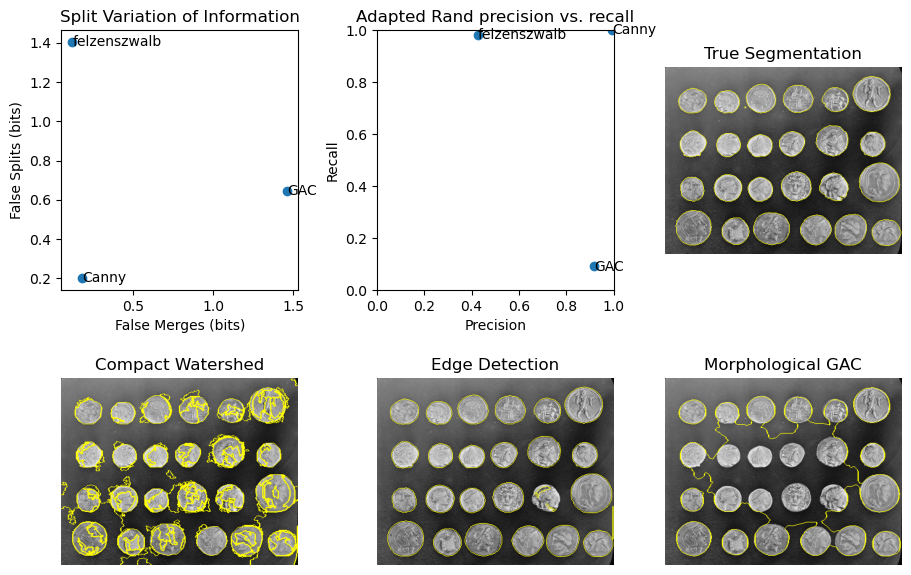

In [36]:
image = img_as_float(image)
gradient = inverse_gaussian_gradient(image)
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
im_test3 = morphological_geodesic_active_contour(gradient, num_iter=100,
                                                 init_level_set=init_ls,
                                                 smoothing=1, balloon=-1,
                                                 threshold=0.69)
im_test3 = label(im_test3)

method_names = ['felzenszwalb', 'Canny filter',
                'Morphological Geodesic Active Contours']
short_method_names = ['felzenszwalb', 'Canny', 'GAC']

precision_list = []
recall_list = []
split_list = []
merge_list = []
for name, im_test in zip(method_names, [im_test1, im_test2, im_test3]):
    error, precision, recall = adapted_rand_error(im_true, im_test)
    splits, merges = variation_of_information(im_true, im_test)
    split_list.append(splits)
    merge_list.append(merges)
    precision_list.append(precision)
    recall_list.append(recall)
    print(f'\n## Method: {name}')
    print(f'Adapted Rand error: {error}')
    print(f'Adapted Rand precision: {precision}')
    print(f'Adapted Rand recall: {recall}')
    print(f'False Splits: {splits}')
    print(f'False Merges: {merges}')

fig, axes = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True)
ax = axes.ravel()

ax[0].scatter(merge_list, split_list)
for i, txt in enumerate(short_method_names):
    ax[0].annotate(txt, (merge_list[i], split_list[i]),
                   verticalalignment='center')
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

ax[1].scatter(precision_list, recall_list)
for i, txt in enumerate(short_method_names):
    ax[1].annotate(txt, (precision_list[i], recall_list[i]),
                   verticalalignment='center')
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Rand precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

ax[2].imshow(mark_boundaries(image, im_true))
ax[2].set_title('True Segmentation')
ax[2].set_axis_off()

ax[3].imshow(mark_boundaries(image, im_test1))
ax[3].set_title('Compact Watershed')
ax[3].set_axis_off()

ax[4].imshow(mark_boundaries(image, im_test2))
ax[4].set_title('Edge Detection')
ax[4].set_axis_off()

ax[5].imshow(mark_boundaries(image, im_test3))
ax[5].set_title('Morphological GAC')
ax[5].set_axis_off()

plt.show()